In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib 
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import seaborn as sns
from scipy.stats import skew
from tqdm import tqdm
import datetime
import os
import pickle
from src import utils


#Environment settings
data_path_in = 'Data/input/'
data_path_out= 'Data/ouput/'

# Loading datasets

In [2]:
# load dataframes 
train = pd.read_csv(data_path_in+'train.csv')
test = pd.read_csv(data_path_in+'test.csv')

print("Train set has shape {}.\nTest set has shape {}" .format(train.shape,test.shape) )

Train set has shape (523021, 36).
Test set has shape (45689, 34)


# Combining train & test data

In [3]:
# Dropping the 2 features not present in test set
train_stripped = train.copy()
train_stripped=train_stripped.drop(columns=['NumberOfCustomers','NumberOfSales'],axis=1)
all_data = pd.concat([train_stripped,test],axis=0).reset_index()

#to restore the original column order
all_data= all_data[list(test.columns.values)]
all_data.shape

(568710, 34)

# 1. Categorical features

In [4]:
cat_features = all_data.select_dtypes(exclude=[np.number])

print("There are {} numeric features ({:.2f}% of total) ".format(cat_features.shape[1],
                                                                 (cat_features.shape[1]/
                                                                  all_data.shape[1])*100))

There are 4 numeric features (11.76% of total) 


In [5]:
all_data.describe(exclude=[np.number])

,Date,StoreType,AssortmentType,Events
count,568710,568710,568710,428171
unique,790,4,3,21
top,22/03/2017,Hyper Market,General,Rain
freq,749,318206,322296,220716


## 1.1 Date manipulation
The Python datetime library provides several useful objects to manipulate times and dates

In [6]:
all_data.Date.head()

0    01/03/2016
1    02/03/2016
2    04/03/2016
3    05/03/2016
4    06/03/2016
Name: Date, dtype: object

In [7]:
all_data.Date=all_data.Date.apply(lambda x:datetime.datetime.strptime(x, '%d/%m/%Y'))
all_data.Date.head()

0   2016-03-01
1   2016-03-02
2   2016-03-04
3   2016-03-05
4   2016-03-06
Name: Date, dtype: datetime64[ns]

## 1.2 Missing Values
As seen by the describe function , the only categorical features with missing values is Events.

In [8]:
print ("There are {} missing values of Events({:.2f}%)".format(all_data['Events'].isna().sum(),
                                                                  all_data['Events'].isna().sum()/
                                                                  all_data.shape[0]*100))

There are 140539 missing values of Events(24.71%)


In [9]:
all_data['Events'].unique()

array(['Rain-Snow', 'Snow', 'Rain', nan, 'Fog-Rain', 'Fog-Rain-Snow',
       'Fog', 'Rain-Thunderstorm', 'Rain-Hail', 'Fog-Rain-Thunderstorm',
       'Fog-Rain-Hail-Thunderstorm', 'Rain-Snow-Hail',
       'Fog-Rain-Snow-Hail', 'Fog-Snow', 'Snow-Hail', 'Fog-Thunderstorm',
       'Thunderstorm', 'Fog-Snow-Hail', 'Rain-Snow-Hail-Thunderstorm',
       'Fog-Rain-Hail', 'Rain-Hail-Thunderstorm',
       'Rain-Snow-Thunderstorm'], dtype=object)

There are 21 unique events (nan included). All events seem to indicate bad weather condition. Let's check what the NaN values could be.

In [10]:
nan_index=all_data[all_data['Events'].isnull()].index.tolist()

print("Precipitation in mm of NaN Events {:.2f} with general mean {:.2f}"
      .format(all_data.loc[nan_index,'Precipitationmm'].mean(),
             all_data['Precipitationmm'].mean()))

print("Mean humidity of NaN Events {:.2f} with general mean {:.2f}"
      .format(all_data.loc[nan_index,'Mean_Humidity'].mean(),
             all_data['Mean_Humidity'].mean()))

print("Mean temperature in C of NaN Events {} with general mean {:.2f}"
      .format(all_data.loc[nan_index,'Mean_TemperatureC'].mean(),
             all_data['Mean_TemperatureC'].mean()))

print("CloudCover of NaN Events {:.2f} with general mean {:.2f}"
      .format(all_data.loc[nan_index,'CloudCover'].mean(),
             all_data['CloudCover'].mean()))

print("Mean visibility in km of NaN Events {:.2f} with general mean {:.2f}"
      .format(all_data.loc[nan_index,'Mean_VisibilityKm'].mean(),
             all_data['Mean_VisibilityKm'].mean()))

Precipitation in mm of NaN Events 0.01 with general mean 0.78
Mean humidity of NaN Events 64.38 with general mean 74.30
Mean temperature in C of NaN Events 10.979016500757798 with general mean 10.01
CloudCover of NaN Events 4.96 with general mean 5.56
Mean visibility in km of NaN Events 15.27 with general mean 12.25


As seen in the previous analysis ,NaN Events have generally less rain ,humidity and cloud cover.<br> The visibility is generally higher whereas the temperature more ore less within the dataset mean. <br>It's seems that NaN events correspond to Normal weather conditions.

In [11]:
all_data.Events = all_data.Events.fillna('Normal')
print ("There are {} missing values of Events left".format(all_data['Events'].isna().sum(),
                                                                  all_data['Events'].isna().sum()/
                                                                  all_data.shape[0]*100))

There are 0 missing values of Events left


# 2. Numerical features

In [12]:
numeric_features = all_data.select_dtypes(include=[np.number])

print("There are {} numeric features ({:.2f}% of total) ".format(numeric_features.shape[1],
                                                                 (numeric_features.shape[1]/
                                                                  all_data.shape[1])*100))


There are 30 numeric features (88.24% of total) 


In [13]:
all_data.describe()

,StoreID,IsHoliday,IsOpen,HasPromotions,NearestCompetitor,Region,Region_AreaKM2,Region_GDP,Region_PopulationK,CloudCover,...,Mean_TemperatureC,Mean_VisibilityKm,Mean_Wind_SpeedKm_h,Min_Dew_PointC,Min_Humidity,Min_Sea_Level_PressurehPa,Min_TemperatureC,Min_VisibilitykM,Precipitationmm,WindDirDegrees
count,568710.000000,568710.000000,568710.000000,568710.000000,568710.000000,568710.000000,568710.000000,568710.000000,568710.000000,519111.000000,...,568710.000000,554751.000000,568710.000000,568710.000000,568710.000000,568710.000000,568710.000000,554751.000000,568710.000000,568710.000000
mean,1373.957616,0.029964,0.829147,0.380157,7999.119534,5.700586,12448.404758,14057.774367,3867.832217,5.560682,...,10.011000,12.250188,11.784913,3.340256,50.406260,1012.401630,5.852888,7.290294,0.780502,171.945909
std,216.381498,0.170489,0.376381,0.485426,11529.083651,3.358435,9197.663508,2753.553082,2814.035417,1.717195,...,6.883573,5.017721,5.878919,5.895683,19.309611,8.925047,6.238434,4.929762,2.551008,102.741075
min,1000.000000,0.000000,0.000000,0.000000,47.000000,0.000000,344.000000,9893.000000,816.000000,0.000000,...,-13.000000,0.000000,2.000000,-18.000000,8.000000,970.000000,-15.000000,0.000000,0.000000,-1.000000
25%,1187.000000,0.000000,1.000000,0.000000,1057.000000,3.000000,7215.000000,11849.000000,1293.000000,5.000000,...,4.000000,10.000000,8.000000,-1.000000,35.000000,1007.000000,1.000000,3.000000,0.000000,75.000000
50%,1373.000000,0.000000,1.000000,0.000000,3321.000000,6.000000,9643.000000,15017.000000,2770.000000,6.000000,...,10.000000,11.000000,11.000000,3.000000,50.000000,1013.000000,6.000000,8.000000,0.000000,194.000000
75%,1561.000000,0.000000,1.000000,1.000000,9673.000000,9.000000,15566.000000,15931.000000,5727.000000,7.000000,...,16.000000,14.000000,14.000000,8.000000,65.000000,1018.000000,11.000000,10.000000,0.250000,254.000000
max,1748.000000,1.000000,1.000000,1.000000,85070.000000,10.000000,32221.000000,23931.000000,8146.000000,8.000000,...,30.000000,31.000000,53.000000,18.000000,100.000000,1038.000000,24.000000,31.000000,58.930000,360.000000


## 2.1 Numerical data correlation

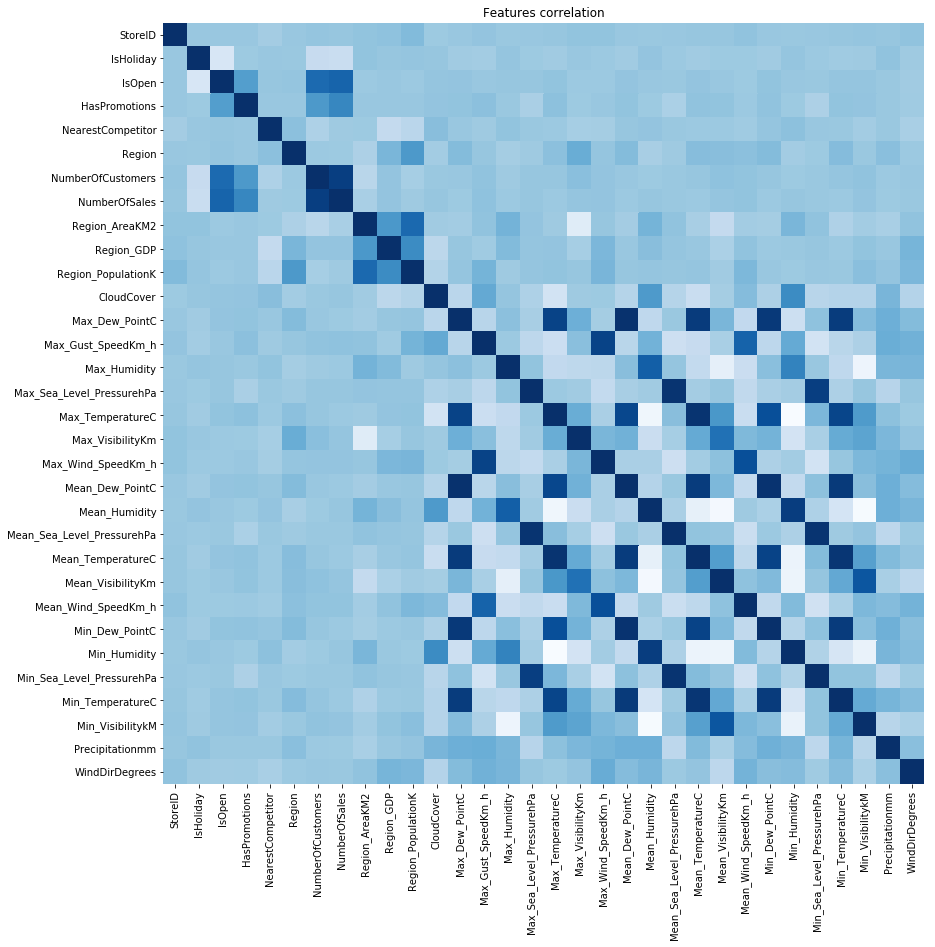

In [14]:
corrmat = train.corr()
plt.subplots(figsize=(14,14))
sns.heatmap(corrmat, square=True, annot=False,cbar=False,cmap="Blues") \
.set_title('Features correlation');

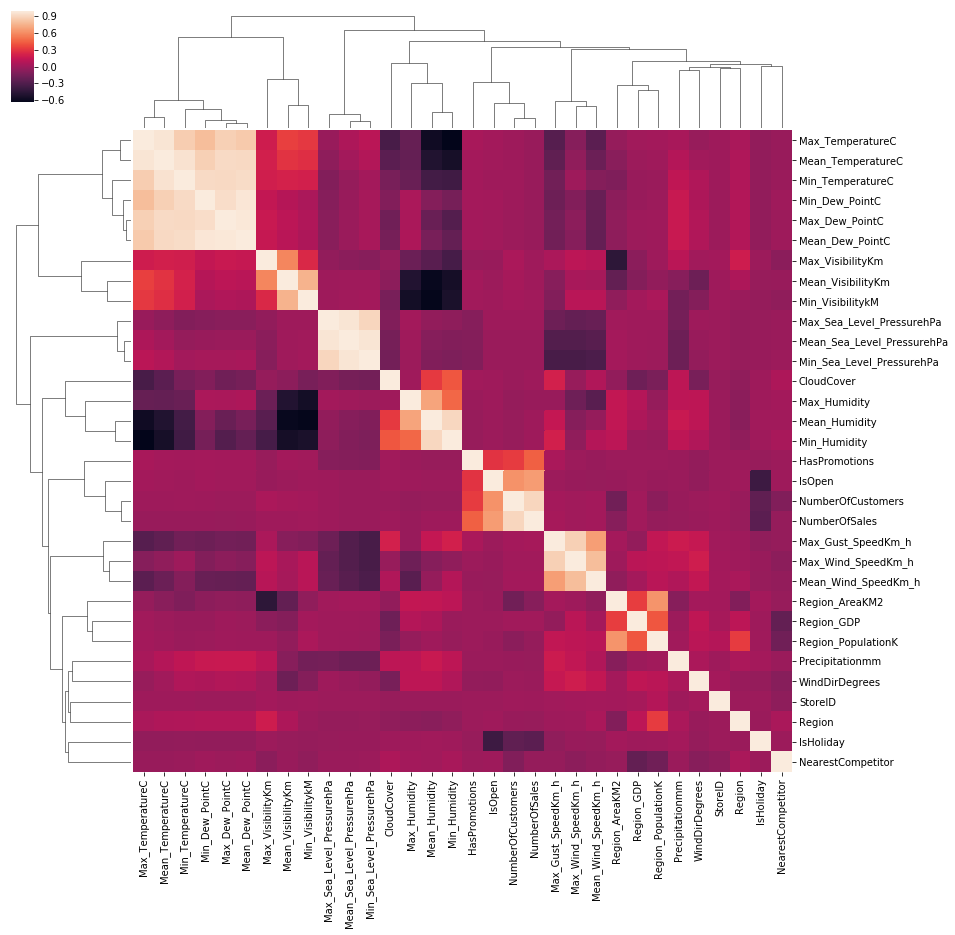

In [15]:
sns.clustermap(corrmat,figsize=(14,14))

## 2.2 Numerical missing values

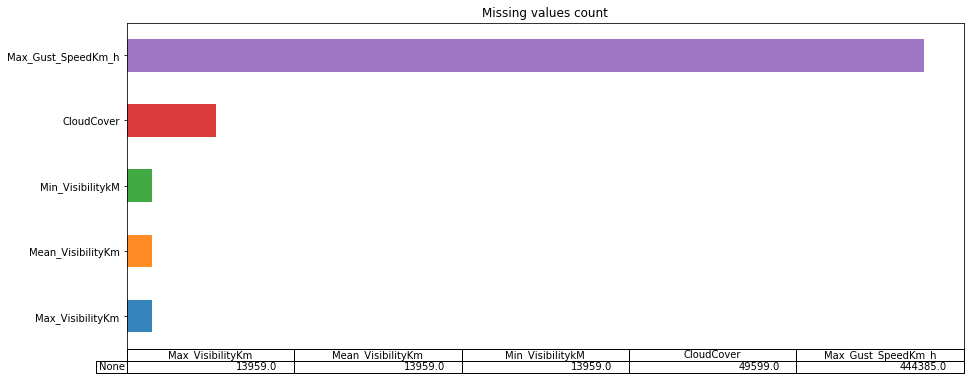

In [16]:
# Missing values# 
plt.figure(figsize=(15,6))
rows_length = numeric_features.shape[0]
numeric_nan_length = numeric_features.isna().sum().where(lambda x : x > 0).dropna()
numeric_nan_length = numeric_nan_length.sort_values()
ax = numeric_nan_length \
.plot(kind='barh', alpha=0.9, title='Missing values count', table=True)
ax.xaxis.set_visible(False) # hide x axis labels

### 2.2.1 Max_Gust_SpeedKm_h

In [17]:
all_data=all_data.drop('Max_Gust_SpeedKm_h',axis=1)
all_data.shape

(568710, 33)

### 2.2.2 Visibility
Since the Visibility has a high negative correlation  with Humidity, a good imputation method could be to group data by Humidity and use the median value to fill in missing values.<br>
Intuitively the minimum visibility corresponds to the maximum humidity and viceversa.<br>
Some humidity levels could not have visiblity values, so a good solution could be to take the mean between the two adiacent values

In [18]:
min_vis_dict=all_data.groupby('Max_Humidity')['Min_VisibilitykM'].apply(lambda x: x.median()).to_dict()
max_vis_dict=all_data.groupby('Min_Humidity')['Max_VisibilityKm'].apply(lambda x: x.median()).to_dict()
mean_vis_dict=all_data.groupby('Mean_Humidity')['Mean_VisibilityKm'].apply(lambda x: x.median()).to_dict()


#Function that replaces missing values of the median with the mean of next and previous values
utils.replace_nan_median([min_vis_dict,max_vis_dict,mean_vis_dict])

#Replacing nan in dataframe 
utils.replace_nan_df(all_data,'Min_VisibilitykM','Max_Humidity',min_vis_dict)
utils.replace_nan_df(all_data,'Max_VisibilityKm','Min_Humidity',max_vis_dict)
utils.replace_nan_df(all_data,'Mean_VisibilityKm','Mean_Humidity',mean_vis_dict)

for col in ["Min_VisibilitykM","Max_VisibilityKm","Mean_VisibilityKm"]:
    print ("There are {} missing values of {} left".
           format(all_data[col].isna().sum(),col))
os.system('say "Visibility Done."')

100%|██████████| 13959/13959 [01:29<00:00, 156.08it/s]


There are 0 missing values of Min_VisibilitykM left
There are 0 missing values of Max_VisibilityKm left
There are 0 missing values of Mean_VisibilityKm left


0

### 2.2.3 CloudCover

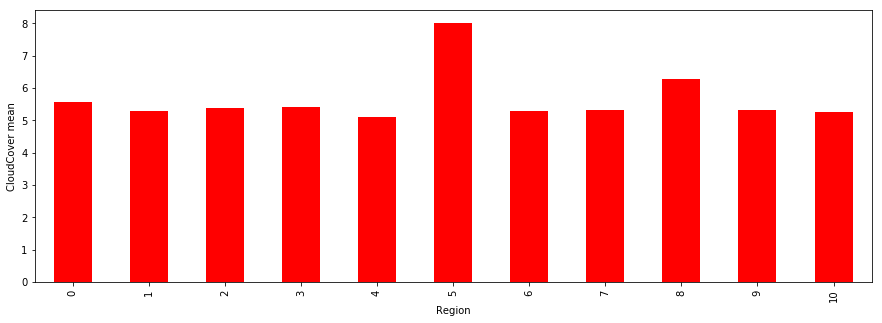

In [19]:
plt.figure(figsize=(15,5))
all_data.groupby(['Region'])['CloudCover'].mean().plot(kind='bar',color='red')
plt.ylabel('CloudCover mean')
plt.show()

In [20]:
index5=all_data[all_data['Region']==5].index.tolist()
all_data.loc[index5,'CloudCover']=8

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score,KFold

rf =  RandomForestClassifier(n_estimators=50,verbose=True)
run_cv = False

cloud_data = all_data.copy()
cloud_data = pd.get_dummies(cloud_data)
cloud_data['Date_delta'] = (cloud_data['Date'] - cloud_data['Date'].min())  / np.timedelta64(1,'D')
cloud_data=cloud_data.drop('Date',axis=1)
nan_indexes=cloud_data[cloud_data['CloudCover'].isnull()].index.tolist()
good_indexes =cloud_data[~cloud_data['CloudCover'].isnull()].index.tolist()

train_cloud = cloud_data.loc[good_indexes]
test_cloud = cloud_data.loc[nan_indexes]
print(train_cloud.shape)
print(test_cloud.shape)

X_train_cloud = train_cloud.copy()
X_train_cloud = X_train_cloud.drop(['CloudCover'], axis=1)
y_train_cloud = train_cloud['CloudCover']
test_cloud = test_cloud.drop('CloudCover',axis=1)

scaler = RobustScaler()
X_train_cloud = scaler.fit_transform(X_train_cloud)
test_cloud = scaler.transform(test_cloud)

# Change boolean to run it
if(run_cv):
    kf = KFold(5, shuffle=True, random_state=42).get_n_splits(X_train_cloud)
    score_CV= cross_val_score(rf,
                              X_train_cloud, 
                              y_train_cloud, 
                              cv = kf)
    
    print("The 10-fold crossvalidation of RF is {:.5f} +/- {:.3f}".format(score_CV.mean(),
                                                                          score_CV.std()))
    os.system('say "Crossvalidation done."')

(524721, 59)
(43989, 59)


In [22]:
rf.fit(X_train_cloud,y_train_cloud)
pred_results =rf.predict(test_cloud)
nan_index=cloud_data[cloud_data['CloudCover'].isnull()].index.tolist()
result_df = pd.DataFrame(data={'Index' : nan_index,
                               'CloudCover': pred_results}).set_index('Index')
#replace missing values
for i in tqdm(nan_index):
    all_data.loc[i,'CloudCover'] = result_df.loc[i,'CloudCover']

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  1.3min finished
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.6s finished
100%|██████████| 43989/43989 [04:29<00:00, 163.27it/s]


# 3. Save clean files

In [28]:
train_clean= all_data[:train.shape[0]].copy()
train_clean['NumberOfSales'] = train.NumberOfSales
train_clean['NumberOfCustomers']= train.NumberOfCustomers
test_clean = all_data[train.shape[0]:]
print(train_clean.shape)
print(test_clean.shape)
#What output should be:
#Train set has shape (523021, 36-1).
#Test set has shape (45689, 34-1)

(523021, 35)
(45689, 33)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523021 entries, 0 to 523020
Data columns (total 35 columns):
StoreID                       523021 non-null int64
Date                          523021 non-null datetime64[ns]
IsHoliday                     523021 non-null int64
IsOpen                        523021 non-null int64
HasPromotions                 523021 non-null int64
StoreType                     523021 non-null object
AssortmentType                523021 non-null object
NearestCompetitor             523021 non-null int64
Region                        523021 non-null int64
Region_AreaKM2                523021 non-null int64
Region_GDP                    523021 non-null int64
Region_PopulationK            523021 non-null int64
CloudCover                    523021 non-null float64
Events                        523021 non-null object
Max_Dew_PointC                523021 non-null int64
Max_Humidity                  523021 non-null int64
Max_Sea_Level_Pres

In [30]:
train_clean.to_csv(data_path_in+'train_clean.csv')
test_clean.to_csv(data_path_in+'test_clean.csv')

# TOO LARGE FOR GITHUB!
# # Serialize dataframes for later use in implementations
# with open(data_path_in+'train_pp.obj', 'wb') as file:
#         pickle.dump(train_clean, file)
# with open(data_path_in+'test_pp.obj', 'wb') as file:
#         pickle.dump(test_clean, file)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 523021 entries, 0 to 523020
Data columns (total 36 columns):
StoreID                       523021 non-null int64
Date                          523021 non-null object
IsHoliday                     523021 non-null int64
IsOpen                        523021 non-null int64
HasPromotions                 523021 non-null int64
StoreType                     523021 non-null object
AssortmentType                523021 non-null object
NearestCompetitor             523021 non-null int64
Region                        523021 non-null int64
NumberOfCustomers             523021 non-null int64
NumberOfSales                 523021 non-null int64
Region_AreaKM2                523021 non-null int64
Region_GDP                    523021 non-null int64
Region_PopulationK            523021 non-null int64
CloudCover                    481840 non-null float64
Events                        398923 non-null object
Max_Dew_PointC                523021 non-null int64